In [48]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [49]:
# NLTK setup
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
df = pd.read_csv("1 - Text preprocessing and Representation/spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']
print(df.head())

# Text cleaning
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return tokens

df['tokens'] = df['message'].apply(clean_text)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erfan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erfan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [50]:
df['label'].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [51]:
sentences = df['tokens'].tolist()
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,
    workers=4,
    epochs=20
)

print("Word2Vec vocabulary size:", len(w2v_model.wv))


Word2Vec vocabulary size: 3835


In [52]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'])
sequences = tokenizer.texts_to_sequences(df['tokens'])

# Pad sequences to the same length
max_len = max(len(s) for s in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df['label'].values

vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)
print("Max sequence length:", max_len)


Vocab size: 8404
Max sequence length: 80


In [53]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [54]:
def build_rnn(model_type='LSTM'):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))  # freeze pretrained embeddings
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(128, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(128, return_sequences=False))
    elif model_type == 'LSTM':
        model.add(LSTM(128, return_sequences=False))
    else:
        raise ValueError("Invalid model_type. Choose from ['SimpleRNN', 'GRU', 'LSTM']")
    
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=1e-3),
                  metrics=['accuracy'])
    return model


In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = ['SimpleRNN', 'GRU', 'LSTM']
histories = {}

for mtype in models:
    print(f"\n Training {mtype} model...")
    model = build_rnn(mtype)
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )
    histories[mtype] = history
    preds = (model.predict(X_test) > 0.5).astype(int)
    print(f"\n Classification report for {mtype}:")
    print(classification_report(y_test, preds))



 Training SimpleRNN model...
Epoch 1/5
56/56 [==============================] - 6s 99ms/step - loss: 0.3282 - accuracy: 0.8724 - val_loss: 0.2446 - val_accuracy: 0.9204
Epoch 2/5
56/56 [==============================] - 5s 96ms/step - loss: 0.1679 - accuracy: 0.9509 - val_loss: 0.2063 - val_accuracy: 0.9283
Epoch 3/5
56/56 [==============================] - 5s 88ms/step - loss: 0.1355 - accuracy: 0.9607 - val_loss: 0.1447 - val_accuracy: 0.9473
Epoch 4/5
56/56 [==============================] - 4s 77ms/step - loss: 0.1198 - accuracy: 0.9647 - val_loss: 0.1436 - val_accuracy: 0.9518
Epoch 5/5
35/35 [==============================] - 1s 23ms/step

 Classification report for SimpleRNN:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.98      0.72      0.83       149

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.91      1115
weighted avg       0.96      0.96  

C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
56/56 [==============================] - 3s 21ms/step - loss: 0.2900 - accuracy: 0.9276 - val_loss: 0.2391 - val_accuracy: 0.9462
Epoch 2/5
56/56 [==============================] - 1s 16ms/step - loss: 0.1232 - accuracy: 0.9624 - val_loss: 0.1242 - val_accuracy: 0.9608
Epoch 3/5
56/56 [==============================] - 1s 14ms/step - loss: 0.0930 - accuracy: 0.9753 - val_loss: 0.1026 - val_accuracy: 0.9697
Epoch 4/5
56/56 [==============================] - 1s 14ms/step - loss: 0.1054 - accuracy: 0.9719 - val_loss: 0.1662 - val_accuracy: 0.9507
Epoch 5/5
35/35 [==============================] - 1s 6ms/step

 Classification report for LSTM:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.95      0.79      0.86       149

    accuracy                           0.97      1115
   macro avg       0.96      0.89      0.92      1115
weighted avg       0.97      0.97      0.97      1115



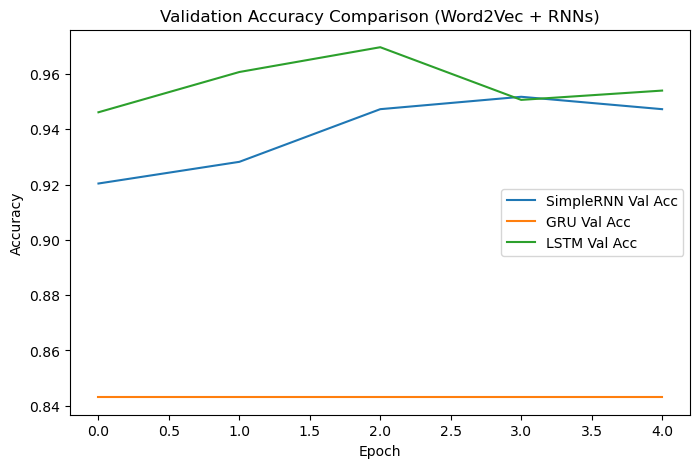

In [56]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
for mtype in models:
    plt.plot(histories[mtype].history['val_accuracy'], label=f'{mtype} Val Acc')
plt.title("Validation Accuracy Comparison (Word2Vec + RNNs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# GLove

In [57]:
# Load dataset
df = pd.read_csv("1 - Text preprocessing and Representation/spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']
print(df.head())

# Text cleaning
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return tokens

df['tokens'] = df['message'].apply(clean_text)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [58]:
# Tokenize text 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'])
sequences = tokenizer.texts_to_sequences(df['tokens'])

# Pad sequences to same length
max_len = max(len(s) for s in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df['label'].values

vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)
print("Max sequence length:", max_len)


Vocab size: 8404
Max sequence length: 80


In [59]:
# Load pretrained GloVe vectors
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Loaded {len(embeddings_index)} GloVe word vectors.")


Loaded 400000 GloVe word vectors.


In [60]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (8404, 100)


In [61]:
from tensorflow.keras.layers import Bidirectional

def build_rnn(model_type='LSTM'):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))  # freeze pretrained GloVe embeddings

    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(128, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(128, return_sequences=False))
    elif model_type == 'LSTM':
        model.add(LSTM(128, return_sequences=False))
    else:
        raise ValueError("Invalid model_type. Choose from ['SimpleRNN', 'GRU', 'LSTM']")
    
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=1e-3),
                  metrics=['accuracy'])
    return model


In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = ['SimpleRNN', 'GRU', 'LSTM']
histories = {}

for mtype in models:
    print(f"\nTraining {mtype} model with GloVe embeddings...")
    model = build_rnn(mtype)
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )
    histories[mtype] = history

    # --- Evaluate ---
    preds = (model.predict(X_test) > 0.5).astype(int)
    print(f"\nClassification report for {mtype}:")
    print(classification_report(y_test, preds))



Training SimpleRNN model with GloVe embeddings...
Epoch 1/5
56/56 [==============================] - 5s 72ms/step - loss: 0.4228 - accuracy: 0.8589 - val_loss: 0.4433 - val_accuracy: 0.8430
Epoch 2/5
56/56 [==============================] - 4s 77ms/step - loss: 0.3999 - accuracy: 0.8712 - val_loss: 0.4479 - val_accuracy: 0.8430
Epoch 3/5
56/56 [==============================] - 5s 90ms/step - loss: 0.3984 - accuracy: 0.8715 - val_loss: 0.4343 - val_accuracy: 0.8430
Epoch 4/5
56/56 [==============================] - 6s 100ms/step - loss: 0.3970 - accuracy: 0.8715 - val_loss: 0.4846 - val_accuracy: 0.8430
Epoch 5/5
35/35 [==============================] - 1s 22ms/step

Classification report for SimpleRNN:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg  

C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
56/56 [==============================] - 3s 23ms/step - loss: 0.4471 - accuracy: 0.8715 - val_loss: 0.4382 - val_accuracy: 0.8430
Epoch 2/5
56/56 [==============================] - 1s 11ms/step - loss: 0.3872 - accuracy: 0.8715 - val_loss: 0.4396 - val_accuracy: 0.8430
Epoch 3/5
56/56 [==============================] - 1s 11ms/step - loss: 0.3890 - accuracy: 0.8715 - val_loss: 0.4352 - val_accuracy: 0.8430
Epoch 4/5
56/56 [==============================] - 1s 12ms/step - loss: 0.3898 - accuracy: 0.8715 - val_loss: 0.4548 - val_accuracy: 0.8430
Epoch 5/5
35/35 [==============================] - 0s 3ms/step

Classification report for GRU:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115


Training LSTM mod

C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erfan\anaconda3\envs\my2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
56/56 [==============================] - 3s 29ms/step - loss: 0.3513 - accuracy: 0.8684 - val_loss: 0.2146 - val_accuracy: 0.8430
Epoch 2/5
56/56 [==============================] - 1s 18ms/step - loss: 0.1903 - accuracy: 0.9158 - val_loss: 0.1957 - val_accuracy: 0.9417
Epoch 3/5
56/56 [==============================] - 1s 13ms/step - loss: 0.1655 - accuracy: 0.9473 - val_loss: 0.1597 - val_accuracy: 0.9529
Epoch 4/5
56/56 [==============================] - 1s 14ms/step - loss: 0.1291 - accuracy: 0.9604 - val_loss: 0.1997 - val_accuracy: 0.9552
Epoch 5/5
35/35 [==============================] - 0s 4ms/step

Classification report for LSTM:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.98      0.72      0.83       149

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



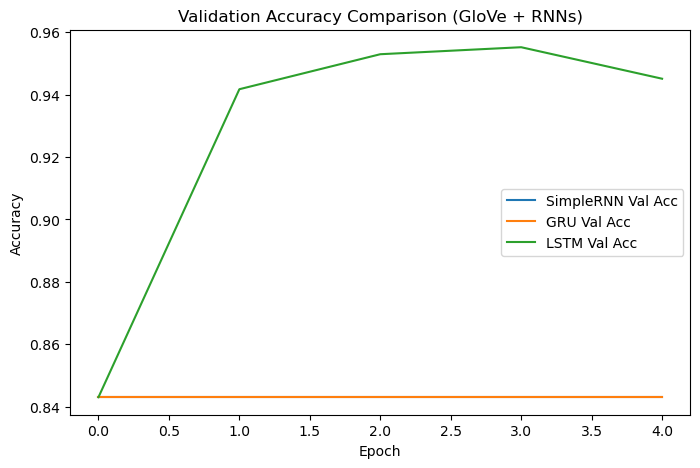

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for mtype in models:
    plt.plot(histories[mtype].history['val_accuracy'], label=f'{mtype} Val Acc')
plt.title("Validation Accuracy Comparison (GloVe + RNNs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
